# GMM Gym

Minimal working example of a GMM!

## 1. Setup

+ 1.1 Set up real deep parameters ($\lambda_0 = f(X, \theta)$)
+ 1.2 Get ValueF and optimal policy function
+ 1.3 Simulate demand and optimal pricing for N firms

## 2. Estimating $\theta$

Try $\theta$ until error < $\varepsilon$

+ 2.1. $\theta$ values generate a $\lambda_0$
+ 2.2. $\lambda_0$ + demand observations + optimal pricing generate pricing decisions
+ 2.3. $error = \left|pricing decisions - observed pricing\right|$


## 1. Setup

In [1]:
import numpy as np
from typing import Callable
%matplotlib inline
import matplotlib.pyplot as plt
import dill
import numpy as np
import pandas as pd
    
import sys
sys.path.append('../')
import src

# Simulation parameters \
########################
σerror= 0.005 #0.01
Nfirms = 300
time_periods = 40
β10, β11 = 0.1, 2
β20, β21 = 0.3, -1

#TODO: consider using an e**x transformation to avoid clipping
def lambda_0v0(x) -> np.ndarray:
    """
    Generate a vector of lambdas on the observables x
    """
    lambda1 = np.clip(β10 + β11*x + np.random.normal(0, σerror), 0, 1)
    lambda2 = np.clip(β20 + β21*x + np.random.normal(0, σerror), 0, 1)
    lambda3 = 1 - lambda1 - lambda2
    return np.array([lambda1, lambda2, lambda3])

def from_theta_to_lamba0v0(θ, x):
    """
    Generates a lambda0 vector from the theta vector and x
    θ = [θ10, θ11, θ20, θ21]
    """
    lambda1 = np.clip(θ[0] + θ[1]*x + np.random.normal(0, σerror), 0, 1)
    lambda2 = np.clip(θ[2] + θ[3]*x + np.random.normal(0, σerror), 0, 1)
    lambda3 = 1 - lambda1 - lambda2
    return np.array([lambda1, lambda2, lambda3])

#Suitable for logistic
β10, β11 = -2, 3
β20, β21 = 0.03, -2.

def logistic(x):
    return 1/(1+np.e**(-x))

def lambda_0(x) -> np.ndarray:
    """
    Generate a vector of lambdas on the observables x
    """
    lambda1 = logistic(β10 + β11*x + np.random.normal(0, σerror))
    maxlambda2_value = 1 - lambda1
    lambda2 = np.clip(logistic(β20 + β21*x + np.random.normal(0, σerror)), 0, maxlambda2_value)
    lambda3 = 1 - lambda1 - lambda2
    return np.array([lambda1, lambda2, lambda3])

def from_theta_to_lamba0(θ, x):
    """
    Generates a lambda0 vector from the theta vector and x
    θ = [θ10, θ11, θ20, θ21]
    x : characteristics of firms
    """
    lambda1 = logistic(θ[0] + θ[1]*x + np.random.normal(0, σerror))
    maxlambda2_value = 1 - lambda1
    lambda2 = np.clip(logistic(θ[2] + θ[3]*x + np.random.normal(0, σerror)), 0, maxlambda2_value)
    lambda3 = logistic(1 - lambda1 - lambda2)
    return np.array([lambda1, lambda2, lambda3])



def get_lambdas_from_x(xs):
    y = np.empty((len(xs), 3))
    for i in range(len(xs)):
        y[i] = lambda_0(xs[i])
    return y

xs = np.abs(np.random.normal(0, 0.18, size=Nfirms))
lambdas0 = get_lambdas_from_x(xs)
lambdas0[0:10]



array([[0.14585984, 0.46892457, 0.38521559],
       [0.19201237, 0.41777754, 0.39021009],
       [0.12406303, 0.50100894, 0.37492803],
       [0.18518151, 0.42350684, 0.39131165],
       [0.27692416, 0.3387459 , 0.38432994],
       [0.17363548, 0.43272667, 0.39363785],
       [0.14482328, 0.47049444, 0.38468227],
       [0.26232495, 0.35143931, 0.38623573],
       [0.19872598, 0.40689442, 0.3943796 ],
       [0.13626548, 0.48197159, 0.38176293]])

In [2]:
file_n = "2018-10-5vfi_dict.dill"
with open('../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)


In [3]:
def many_runs(nfirms, **kwargs):
    dfs = []
    for firm_i in range(nfirms):
        df = src.simulate_one_firm(valueF, policyF,
                                   maxt=time_periods,
                                   lambda0=lambdas0[firm_i], **kwargs)
        df['firm'] = firm_i
        dfs.append(df)
        
    return pd.concat(dfs, axis=0)


df = many_runs(Nfirms)

## Estimating $\theta$

+ 2.1. $\theta$ values generate a $\lambda_0$

(defined aboved)

+ 2.2. $\lambda_0$ + demand observations + optimal pricing generate pricing decisions

In [60]:
src.generate_pricing_decisions(policyF, np.array([0.2, 0.6, 0.2]),
                               df[df.firm == 15].log_dmd.values)[0:4]

array([2.32068966, 1.46819105, 1.36664524, 1.25887915])

+ 2.3. $error = \left|pricing decisions - observed pricing\right|$

+ Do I choose moments?

In [26]:
test_df = pd.DataFrame({'level_prices': [2., 3., 4., 1., 2.1, 2.1, 2.1, 2.5],
                       'firm': [0, 0, 0, 0, 0, 1, 1, 1],
                       't': [0, 1, 2, 3, 4, 0, 1, 2]})

test_df.groupby('firm')[['level_prices', 't']].rolling(window=3).std()

level_prices    t
firm                     
0    0           NaN  NaN
     1           NaN  NaN
     2      1.000000  1.0
     3      1.527525  1.0
     4      1.517674  1.0
1    5           NaN  NaN
     6           NaN  NaN
     7      0.230940  1.0

In [40]:
#Generate running std (to start)
std_devs = (df.groupby('firm').level_prices.rolling(window=4, min=3)
            .std().reset_index()
            .rename(columns={'level_1': 't',
                            'level_prices': 'std_dev_prices'}))

df = pd.merge(df, std_devs, on=['firm', 't'], how='left')

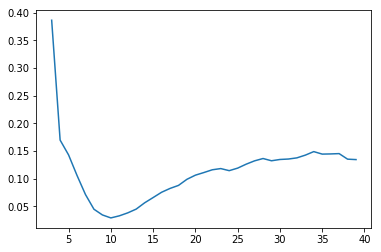

In [80]:

def generate_mean_std_pricing_decisions(policyF, lambda0, min_periods=3):
    pricing_decision_dfs = []
    for firm in df.firm.unique():
        prices = src.generate_pricing_decisions(policyF, lambda0,
                                       df[df.firm == firm].log_dmd.values)
        pricing_decision_dfs.append(pd.DataFrame({'level_prices': prices,
                                    'firm': np.repeat(firm, len(prices))
                                  }))
        
    pricing_decision_df = pd.concat(pricing_decision_dfs, axis=0)
                                        
                                        
    std_dev_df = (pricing_decision_df.groupby('firm').level_prices.rolling(window=4,
                                                            min=min_periods)
            .std().reset_index()
            .rename(columns={'level_1': 't',
                            'level_prices': 'std_dev_prices'}))
    
    return std_dev_df.groupby('t').std_dev_prices.mean()[min_periods:]
                                        
                              
                                        
avers = generate_mean_std_pricing_decisions(policyF, np.array([0.2, 0.6, 0.2]))
plt.plot(avers)

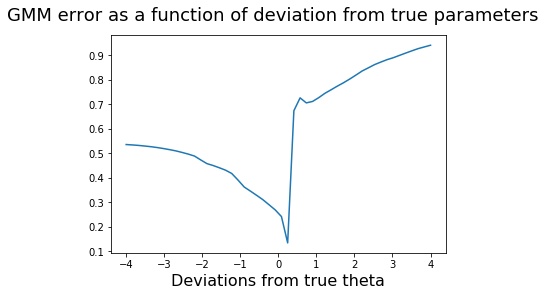

In [107]:
def std_moments_error(θ: np.ndarray, policyF, x, observed_log_dmd,
                      mean_std_observed_prices, min_periods=3) -> float:
    """
    Computes the norm of the different between the observed moments and
    the moments predicted by the model + θ
    
    Moments: average (over firms) standard deviation for each time period
    
    x: characteristics of firms
    mean_std_observed_prices: mean (over firms) of standard deviation per t
    """
    #CHANGE THIS: Loop over different Xs! Each firm should have its own X
    lambda0 = from_theta_to_lamba0(θ, x)
    mean_std_expected_prices = generate_mean_std_pricing_decisions(policyF,
                                                lambda0, min_periods)
    
    return np.linalg.norm(mean_std_expected_prices.values 
                          - mean_std_observed_prices.values)

min_periods = 3

mean_std_observed_prices = df.groupby('t').std_dev_prices.mean()[min_periods:]

real_theta = np.array([-2, 3, 0.03, -2])

error = []
deviation = np.linspace(-4, 4, 50)
thetas = real_theta + deviation[:, np.newaxis]

for theta in thetas:
    error.append(std_moments_error(theta, policyF, xs[3], 737, mean_std_observed_prices,
                 min_periods=3))
    
fig, ax = plt.subplots(1, 1)
ax.plot(deviation, error)
ax.set_xlabel("Deviations from true theta", size=16)
fig.suptitle("GMM error as a function of deviation from true parameters", size=18);

In [103]:
thetas = real_theta + 
thetas.shape

(50, 4)

1.2999150967298112 1.2869394664881244 1.1539347845185266


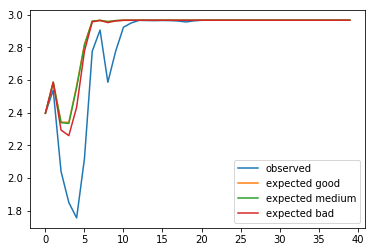

In [136]:
def error(θ: np.ndarray, x, observed_log_dmd, observed_prices) -> float:
    lambda0 = from_theta_to_lamba0(θ, x)
    expected_prices = generate_pricing_decisions(lambda0, observed_log_dmd)
    return np.linalg.norm(expected_prices - observed_prices)


firm_id = 90
chosen_x = xs[firm_id]
chosen_dmd = df[df.firm == firm_id].log_dmd.values
chosen_prices = df[df.firm == firm_id].level_prices.values


def error_diagnostic(θ, x, observed_log_dmd, observed_prices):
    lambda0 = from_theta_to_lamba0(θ, x)
    expected_prices = generate_pricing_decisions(lambda0, observed_log_dmd)
    return observed_prices, expected_prices, np.linalg.norm(expected_prices - observed_prices)

def error_w_data(θ) -> float:
    return error(θ, chosen_x, chosen_dmd, chosen_prices)


trueθ0 = np.array([β10, β11, β20, β21])
mediumθ0 = np.array([β10+0.1, β11-0.1, β20+0.01, β21-0.01])
badθ0 = np.array([β10+0.3, β11-0.05, β20+0.1, β21-0.05])
obs_pr, exp_pr, norm1 = error_diagnostic(trueθ0, chosen_x, chosen_dmd, chosen_prices)
obs_prmedium, exp_prmedium, norm2 = error_diagnostic(mediumθ0, chosen_x, chosen_dmd, chosen_prices)
obs_prbad, exp_prbad, norm3 = error_diagnostic(badθ0, chosen_x, chosen_dmd, chosen_prices)

print(norm1, norm2, norm3)
fig, ax = plt.subplots(1, 1)
ax.plot(obs_pr, label='observed')
ax.plot(exp_pr, label="expected good")
ax.plot(exp_prmedium, label="expected medium")
ax.plot(exp_prbad, label="expected bad")
ax.legend();

## 3. Optimize

## Optimize with moments

In [108]:
min_periods = 3

mean_std_observed_prices = df.groupby('t').std_dev_prices.mean()[min_periods:]

def error_w_data(θ):
    return std_moments_error(θ, policyF, x=xs[4], observed_log_dmd=34234,
                      mean_std_observed_prices=mean_std_observed_prices,
                             min_periods=3)



0.2589614663808846

In [110]:
true_params

array([-2.  ,  3.  ,  0.03, -2.  ])

In [112]:
badθ0

array([ 0.  ,  2.  ,  1.03, -5.  ])

In [109]:
from scipy import optimize as opt
true_params = np.array([β10, β11, β20, β21])
mediumθ0 = np.array([β10+0.1, β11-0.1, β20+0.01, β21-0.01])
badθ0 = np.array([β10+2, β11-1, β20+1, β21-3])

opt.minimize(error_w_data, badθ0,
             method='Nelder-Mead', options={'maxiter': 300, 'disp': True})

 final_simplex: (array([[-1.91629911,  3.02138363,  0.04399795, -1.78308427],
       [-1.91629911,  3.02138363,  0.04399795, -1.78308427],
       [-1.91629911,  3.02138363,  0.04399795, -1.78308427],
       [-1.91629911,  3.02138363,  0.04399795, -1.78308427],
       [-1.91629911,  3.02138363,  0.04399795, -1.78308427]]), array([0.18105796, 0.18779112, 0.19303533, 0.19399585, 0.19759756]))
           fun: 0.18105795953845957
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 797
           nit: 300
        status: 2
       success: False
             x: array([-1.91629911,  3.02138363,  0.04399795, -1.78308427])

In [115]:
print("eheheheh")

eheheheh


In [114]:
opt.differential_evolution(error_w_data, [(-3, 3), (-3, 3), (-3, 3), (-3, 3)],
                          maxiter=3)


     fun: 0.0785668023165704
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 375
     nit: 3
 success: False
       x: array([-1.37999293, -1.04929022,  0.04737885,  1.31836641])

## Nelder-Mead

Doesn't converge. Not super surprised, since the problem is weird

In [141]:
from scipy import optimize as opt
#minimize(f, x0,, method='Nelder-Mead')
true_params = np.array([β10, β11, β20, β21])
mediumθ0 = np.array([β10+0.1, β11-0.1, β20+0.01, β21-0.01])
badθ0 = np.array([β10+2, β11-1, β20+1, β21-3])
opt.minimize(error_w_data, badθ0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})

 final_simplex: (array([[ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00]]), array([1.91533241, 1.9243984 , 1.9332215 , 1.93347883, 1.93582771]))
           fun: 1.9153324053720298
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 13571
           nit: 5000
        status: 2
       success: False
             x: array([ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00, -4.99999927e+00])

## Differential Evolution

Does converge! Seems promising even though it's slow

In [144]:
opt.differential_evolution(error_w_data, [(-3, 3), (-3, 3), (-3, 3), (-3, 3)],
                          maxiter=1000)

     fun: 0.048427970155213274
 message: 'Optimization terminated successfully.'
    nfev: 7965
     nit: 130
 success: True
       x: array([-1.36566532,  0.48591431,  0.67631488, -2.59839081])